In [109]:
import pandas as pd
import numpy as np
import os

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [4]:
# load data
file_path = os.path.join('data','myo5b_variants_patho_benign_cadd1.3fullannot_v1.xlsx')
data = pd.ExcelFile(file_path)
data = data.parse(data.sheet_names[0])
data.head()

,CHROM,POS,ID,REF,ALT,INFO,Type,Length,isTv,isDerived,...,Intron,oAA,nAA,Grantham,PolyPhenCat,PolyPhenVal,SIFTcat,SIFTval,RawScore,PHRED
0,18,47352774,MYO5B:c.5616-2A>G,T,C,Pathogenic,SNV,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.334537,6.023
1,18,47361716,MYO5B:c.5392C>T,G,A,Pathogenic,SNV,0,False,True,...,NaN,Q,*,NaN,NaN,NaN,NaN,NaN,14.849415,48.000
2,18,47361725,MYO5B:c.5383C>T,G,A,Pathogenic,SNV,0,False,True,...,NaN,R,*,NaN,NaN,NaN,NaN,NaN,15.701726,52.000
3,18,47365526,MYO5B:c.4840C>T,G,A,Pathogenic,SNV,0,False,True,...,NaN,Q,*,NaN,NaN,NaN,NaN,NaN,14.577744,46.000
4,18,47365610,MYO5B:c.4755_4756dupT,C,CCA,Pathogenic,INS,2,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.553096,35.000


In [44]:
data_no_null = data

In [45]:
# delete columns with less than 30% values
null_thres = data.shape[0] * 0.3
for col in data.columns:
    null = data[col].isnull().values.ravel().sum()
    if null > null_thres:
        data_no_null = data_no_null.drop([col],axis=1)
# delete 'CHROM', 'ID', 'GeneID','FeatureID','GeneName'
del_list = ['CHROM', 'ID', 'GeneID','FeatureID','GeneName','PHRED','RawScore']
data_no_null = data_no_null.drop(del_list,axis=1)

In [46]:
# select only numerical data
data_x = data_no_null[[col for col in data_no_null.columns if data_no_null[col].dtype != np.object]]
data_x = data_x.fillna(0)
data_y = data_no_null['INFO'].astype('category')

In [47]:
# logistic regression model
logr = LogisticRegression()
logr.fit(data_x,data_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [60]:
print(data_x.columns.shape)
print(logr.coef_.shape)
print(logr.intercept_)

(54,)
(1, 54)
[ -1.11073624e-13]


In [71]:
# pca
pca = PCA(n_components=8)
data_x_pca = pca.fit_transform(data_x)
print(pca.components_.shape)
print(pca.explained_variance_)

(8, 54)
[  1.67613840e+10   4.39597752e+09   5.76826761e+08   1.85081419e+06
   1.29343421e+06   6.19369864e+04   1.88917471e+03   9.25226293e+02]


In [72]:
# pca+LogisticRegression
logr.fit(data_x_pca,data_y)
pred = logr.predict(data_x_pca)
confusion_matrix(data_y,pred)

array([[193,   2],
       [ 51,   2]])

In [103]:
# draw a overlapping bar graph for pandas dataframes
def overlapped_bar(df, show=False, width=0.9, alpha=.5,
                   title='', xlabel='', ylabel='', **plot_kwargs):
    """Like a stacked bar chart except bars on top of each other with transparency"""
    xlabel = xlabel or df.index.name
    N = len(df)
    M = len(df.columns)
    indices = np.arange(N)
    colors = ['steelblue', 'firebrick', 'darksage', 'goldenrod', 'gray'] * int(M / 5. + 1)
    for i, label, color in zip(range(M), df.columns, colors):
        kwargs = plot_kwargs
        kwargs.update({'color': color, 'label': label})
        plt.bar(indices, df[label], width=width, alpha=alpha if i else 1, **kwargs)
        plt.xticks(indices + .5 * width,
                   ['{}'.format(idx) for idx in df.index.values])
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    if show:
        plt.show()
    return plt.gcf()

In [132]:
# calculate the feature importance for each class
path_data_x = data_x[data_y=='Pathogenic'].mean()
beni_data_x = data_x[data_y=='Benign'].mean()
featu_impor = pca.components_*(logr.coef_.reshape((8,1)))
featu_impor_path = np.log(abs(featu_impor.sum(axis=0)*path_data_x))
featu_impor_beni = np.log(abs(featu_impor.sum(axis=0)*beni_data_x))

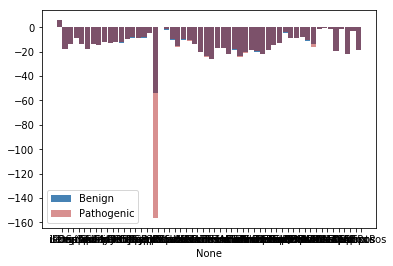

In [137]:
# show the differences in two classes
df = pd.DataFrame(np.matrix([featu_impor_beni,featu_impor_path]).T, columns=['Benign', 'Pathogenic'],
                  index=featu_impor_beni.keys())
overlapped_bar(df, show=True)